In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import itertools
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

<ipython-input-1-828121b0565c>:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
data=pd.read_excel(r"../SAMSUNG/결과1.xlsx")
data

,SalesOrderNumber,OrderDate,CategoryName,SubcategoryName,UnitPrice,OrderQuantity,Discount %
0,IN-2017-47883,2017-01-01,Furniture,Furnishings,25.260,5,0.5
1,IZ-2017-4680,2017-01-03,Furniture,Chairs,166.710,4,0.6
2,ID-2017-80230,2017-01-03,Furniture,Chairs,57.390,2,0.2
3,ID-2017-80230,2017-01-03,Furniture,Chairs,132.870,2,0.0
4,ES-2017-4869686,2017-01-03,Furniture,Bookcases,122.070,7,0.6
...,...,...,...,...,...,...,...
18567,CA-2014-110422,2014-01-21,Furniture,Furnishings,25.248,3,0.2
18568,CA-2017-121258,2017-02-26,Furniture,Furnishings,91.960,2,0.0
18569,CA-2017-121258,2017-02-26,Technology,Phones,258.576,2,0.2
18570,CA-2017-121258,2017-02-26,Office Supplies,Paper,29.600,4,0.0


In [4]:
furniture=data.loc[data['CategoryName'] == 'Furniture']
office=data.loc[data['CategoryName'] == 'Office Supplies']

In [7]:
furniture= furniture.groupby('OrderDate')['OrderQuantity'].sum().reset_index()
office= office.groupby('OrderDate')['OrderQuantity'].sum().reset_index()

In [8]:
furniture = furniture.set_index('OrderDate')
office = office.set_index('OrderDate')

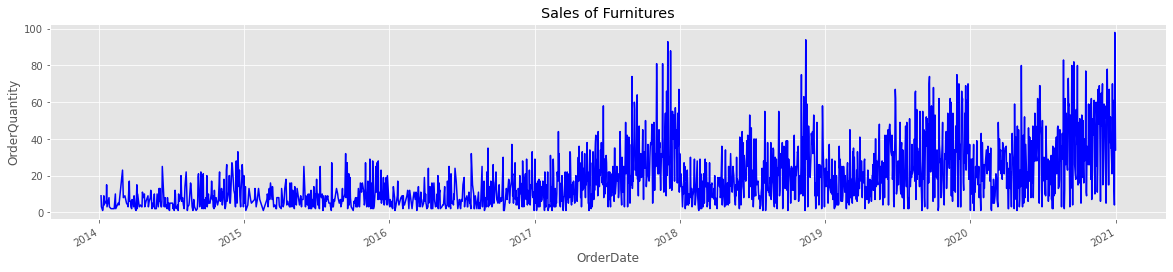

In [10]:
ax= furniture['OrderQuantity'].plot(color='blue',figsize=(20,4))
ax.set_xlabel("OrderDate")
ax.set_ylabel('OrderQuantity')
ax.set_title("Sales of Furnitures")
plt.show()

In [11]:
df = furniture['OrderQuantity'].resample('MS').mean()

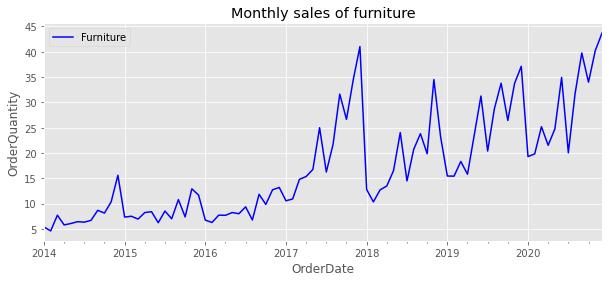

In [12]:
df.plot(figsize=(10, 4),color='blue',label = 'Furniture')

#avg_technology_sales.plot(figsize=(10, 4),color='red',label = 'Technology')

#avg_office_sales.plot(figsize=(10, 4),color='green',label = 'Office Supplies')
plt.xlabel("OrderDate")
plt.ylabel('OrderQuantity')
plt.title("Monthly sales of furniture")
plt.legend()
plt.show()

In [13]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

def performance2(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

In [21]:
train, test = np.array(df[:-12]), np.array(df[-12:])
train= train.reshape(-1,1)
test= test.reshape(-1,1)

In [22]:
#Scale train and test data to [-1, 1]
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [23]:
n_input = 12
# univariate
n_features = 1
#TimeseriesGenerator automatically transform a univariate time series dataset into a supervised learning problem.
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=10)

In [24]:
n=3
store= np.zeros((12,n))
for i in range(n):
    model_vanilla = Sequential()
    model_vanilla.add(LSTM(50, activation='relu', input_shape=(12, 1)))
    #Add layer
    model_vanilla.add(Dense(100, activation='relu'))
    model_vanilla.add(Dense(100, activation='relu'))
    #Output
    model_vanilla.add(Dense(1))
    model_vanilla.compile(optimizer='adam', loss='mse')
    # 22
    model_vanilla.fit_generator(generator,epochs=200)
    
    pred_list = []

    batch = train[-n_input:].reshape((1, n_input, n_features))

    for j in range(n_input):   
        pred_list.append(model_vanilla.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:],[[pred_list[j]]],axis=1)

    df_predict_vanilla = pd.DataFrame(scaler.inverse_transform(pred_list),
                              index=df[-n_input:].index, columns=['Prediction'])

    
    store[:,i]=df_predict_vanilla['Prediction']
print(store)

Epoch 1/200
6/6 [==============================] - 1s 6ms/step - loss: 0.1471
Epoch 2/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1171
Epoch 3/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0745
Epoch 4/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0458
Epoch 5/200
6/6 [==============================] - ETA: 0s - loss: 0.088 - 0s 6ms/step - loss: 0.0436
Epoch 6/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0416
Epoch 7/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0428
Epoch 8/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0384
Epoch 9/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0347
Epoch 10/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0342
Epoch 11/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0331
Epoch 12/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0312
Epoch 13/200
6/6 [===================

6/6 [==============================] - 0s 5ms/step - loss: 0.0161
Epoch 105/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0165
Epoch 106/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0184
Epoch 107/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0167
Epoch 108/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0173
Epoch 109/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0183
Epoch 110/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0182
Epoch 111/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0188
Epoch 112/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0169
Epoch 113/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0182
Epoch 114/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0161
Epoch 115/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0153
Epoch 116/200
6/6 [==============================] - 0

6/6 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 7/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0375
Epoch 8/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0366
Epoch 9/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0349
Epoch 10/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0338
Epoch 11/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0339
Epoch 12/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0323
Epoch 13/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0318
Epoch 14/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0310
Epoch 15/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0319
Epoch 16/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0305
Epoch 17/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0311
Epoch 18/200
6/6 [==============================] - 0s 6ms/step - lo

6/6 [==============================] - 0s 6ms/step - loss: 0.0181
Epoch 110/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0164
Epoch 111/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0177
Epoch 112/200
6/6 [==============================] - 0s 7ms/step - loss: 0.0177
Epoch 113/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0173
Epoch 114/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0173
Epoch 115/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0171
Epoch 116/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0168
Epoch 117/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0168
Epoch 118/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0168
Epoch 119/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0164
Epoch 120/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0173
Epoch 121/200
6/6 [==============================] - 0

6/6 [==============================] - 0s 5ms/step - loss: 0.0293
Epoch 12/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0288
Epoch 13/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0280
Epoch 14/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0297
Epoch 15/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0271
Epoch 16/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0281
Epoch 17/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0271
Epoch 18/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0271
Epoch 19/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0268
Epoch 20/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0267
Epoch 21/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0260
Epoch 22/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0266
Epoch 23/200
6/6 [==============================] - 0s 6ms/step -

6/6 [==============================] - 0s 5ms/step - loss: 0.0148
Epoch 115/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0171
Epoch 116/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0176
Epoch 117/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0175
Epoch 118/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0156
Epoch 119/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0149
Epoch 120/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0177
Epoch 121/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0188
Epoch 122/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0156
Epoch 123/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0187
Epoch 124/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0148
Epoch 125/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0165
Epoch 126/200
6/6 [==============================] - 0

In [29]:
final_vanilla= np.zeros((store.shape[0],1))

#final_vanilla= np.zeros((store.shape[0],1))
for i in range(store.shape[0]):
    
    final_vanilla[i]=np.mean(store[i,:])
final_vanilla=final_vanilla.reshape((12,))

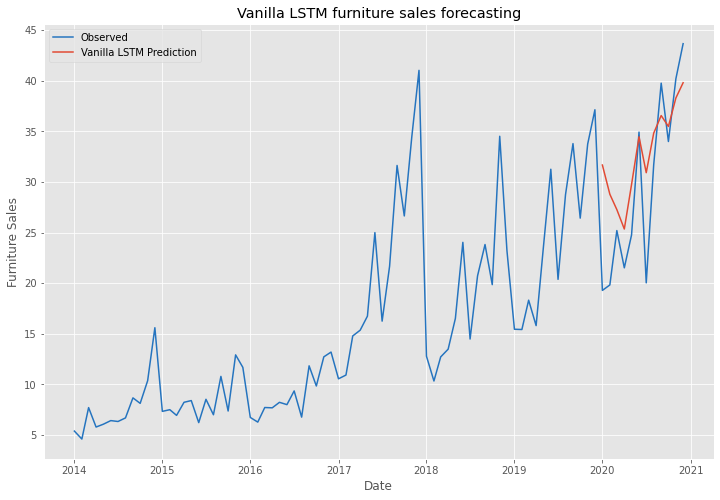

In [35]:
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df[72:].index,final_vanilla,label="Vanilla LSTM Prediction")
plt.title('Vanilla LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [36]:
vanilla_lstm= performance(df[-12:],final_vanilla)
vanilla_lstm # 여기까지가 vanilla lstm

{'MSE': 36.41, 'RMSE': 6.03, 'MAPE': 20.59}

In [37]:
n=3
store2= np.zeros((12,n))
for i in range(n):
    model_stacked = Sequential()
    #In stacked LSTM, we should output a sequence rather than a single value for each input -> return_sequences=True
    model_stacked.add(LSTM(50, activation='relu', return_sequences = True, input_shape=(12, 1)))
    model_stacked.add(LSTM(50, activation='relu'))
    model_stacked.add(Dense(100, activation='relu'))
    model_stacked.add(Dense(50, activation='relu'))
    model_stacked.add(Dense(1))
    model_stacked.compile(optimizer='adam', loss='mse')
    model_stacked.fit_generator(generator,epochs=200)
    
    pred_list_s = []

    batch = train[-n_input:].reshape((1, n_input, n_features))

    for j in range(n_input):   
        pred_list_s.append(model_stacked.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:],[[pred_list_s[j]]],axis=1)

    df_predict_stacked = pd.DataFrame(scaler.inverse_transform(pred_list_s),
                              index=df[-n_input:].index, columns=['Prediction'])

    
    store2[:,i]=df_predict_stacked['Prediction']
print(store2)

Epoch 1/200
6/6 [==============================] - 2s 11ms/step - loss: 0.1529
Epoch 2/200
6/6 [==============================] - 0s 10ms/step - loss: 0.1053
Epoch 3/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0658
Epoch 4/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0496
Epoch 5/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0516
Epoch 6/200
6/6 [==============================] - 0s 8ms/step - loss: 0.0447
Epoch 7/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0458
Epoch 8/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0452
Epoch 9/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0419
Epoch 10/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0395
Epoch 11/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0384
Epoch 12/200
6/6 [==============================] - 0s 10ms/step - loss: 0.0368
Epoch 13/200
6/6 [==============================] - 0s 8ms

6/6 [==============================] - 0s 9ms/step - loss: 0.0204
Epoch 105/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0207
Epoch 106/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0180
Epoch 107/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0200
Epoch 108/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0208
Epoch 109/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0180
Epoch 110/200
6/6 [==============================] - 0s 8ms/step - loss: 0.0194
Epoch 111/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0204
Epoch 112/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0205
Epoch 113/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0204
Epoch 114/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0230
Epoch 115/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0197
Epoch 116/200
6/6 [==============================] - 0

6/6 [==============================] - 0s 9ms/step - loss: 0.0438
Epoch 7/200
6/6 [==============================] - 0s 8ms/step - loss: 0.0463
Epoch 8/200
6/6 [==============================] - 0s 7ms/step - loss: 0.0434
Epoch 9/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0417
Epoch 10/200
6/6 [==============================] - 0s 8ms/step - loss: 0.0408
Epoch 11/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0404
Epoch 12/200
6/6 [==============================] - 0s 8ms/step - loss: 0.0399
Epoch 13/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0370
Epoch 14/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0369
Epoch 15/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0359
Epoch 16/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0356
Epoch 17/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0368
Epoch 18/200
6/6 [==============================] - 0s 9ms/step - lo

6/6 [==============================] - 0s 10ms/step - loss: 0.0154
Epoch 110/200
6/6 [==============================] - 0s 8ms/step - loss: 0.0157
Epoch 111/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0158
Epoch 112/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0147
Epoch 113/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0149
Epoch 114/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0165
Epoch 115/200
6/6 [==============================] - 0s 10ms/step - loss: 0.0180
Epoch 116/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0184
Epoch 117/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0185
Epoch 118/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0175
Epoch 119/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0151
Epoch 120/200
6/6 [==============================] - 0s 10ms/step - loss: 0.0144
Epoch 121/200
6/6 [==============================] 

6/6 [==============================] - 0s 10ms/step - loss: 0.0395
Epoch 12/200
6/6 [==============================] - 0s 10ms/step - loss: 0.0421
Epoch 13/200
6/6 [==============================] - 0s 10ms/step - loss: 0.0405
Epoch 14/200
6/6 [==============================] - 0s 11ms/step - loss: 0.0372
Epoch 15/200
6/6 [==============================] - 0s 10ms/step - loss: 0.0362
Epoch 16/200
6/6 [==============================] - 0s 11ms/step - loss: 0.0358
Epoch 17/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0344
Epoch 18/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0348
Epoch 19/200
6/6 [==============================] - 0s 10ms/step - loss: 0.0343
Epoch 20/200
6/6 [==============================] - 0s 11ms/step - loss: 0.0333
Epoch 21/200
6/6 [==============================] - 0s 11ms/step - loss: 0.0343
Epoch 22/200
6/6 [==============================] - 0s 11ms/step - loss: 0.0334
Epoch 23/200
6/6 [==============================] - 0s 

6/6 [==============================] - 0s 10ms/step - loss: 0.0180
Epoch 114/200
6/6 [==============================] - 0s 12ms/step - loss: 0.0192: 0s - loss: 0.019
Epoch 115/200
6/6 [==============================] - 0s 13ms/step - loss: 0.0220
Epoch 116/200
6/6 [==============================] - 0s 12ms/step - loss: 0.0155
Epoch 117/200
6/6 [==============================] - 0s 12ms/step - loss: 0.0169
Epoch 118/200
6/6 [==============================] - 0s 10ms/step - loss: 0.0160
Epoch 119/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0161
Epoch 120/200
6/6 [==============================] - 0s 11ms/step - loss: 0.0158
Epoch 121/200
6/6 [==============================] - 0s 10ms/step - loss: 0.0163
Epoch 122/200
6/6 [==============================] - 0s 10ms/step - loss: 0.0163
Epoch 123/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0165
Epoch 124/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0174
Epoch 125/200
6/6 [========

In [38]:
final_stacked2= np.zeros((store2.shape[0],1))
for i in range(store2.shape[0]):
    
    final_stacked2[i]=np.mean(store2[i,:])
final_stacked2=final_stacked2.reshape((12,))

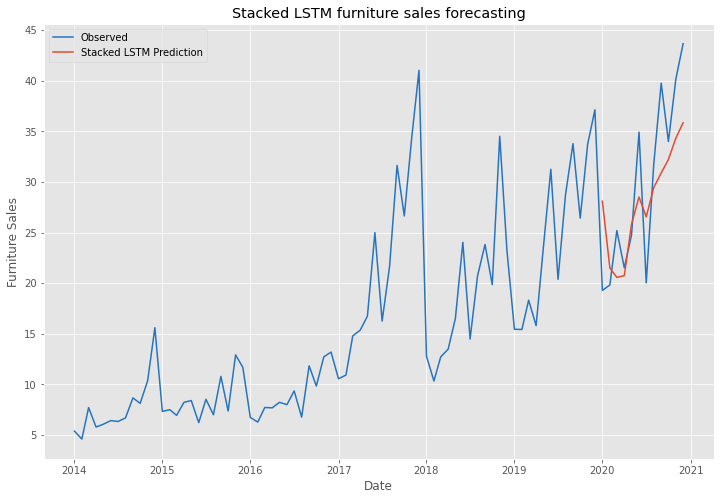

In [40]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df[72:].index,final_stacked2,label="Stacked LSTM Prediction")
plt.title('Stacked LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [41]:
stacked_lstm= performance(df[-12:],final_stacked2)
stacked_lstm # stacked lstm

{'MSE': 30.82, 'RMSE': 5.55, 'MAPE': 16.54}

In [42]:
# define model
warnings.filterwarnings("ignore")
model_bi = Sequential()
model_bi.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(12, 1)))
model_bi.add(Dense(1))
model_bi.compile(optimizer='adam', loss='mse')

In [43]:
model_bi.fit_generator(generator,epochs=200)

Epoch 1/200
6/6 [==============================] - 2s 6ms/step - loss: 0.1636
Epoch 2/200
6/6 [==============================] - 0s 7ms/step - loss: 0.1295
Epoch 3/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0947
Epoch 4/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0765
Epoch 5/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0529
Epoch 6/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0418
Epoch 7/200
6/6 [==============================] - 0s 7ms/step - loss: 0.0397
Epoch 8/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0396
Epoch 9/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0369
Epoch 10/200
6/6 [==============================] - 0s 7ms/step - loss: 0.0357
Epoch 11/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0356
Epoch 12/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0348
Epoch 13/200
6/6 [==============================] - 0s 7ms/st

6/6 [==============================] - 0s 8ms/step - loss: 0.0177
Epoch 105/200
6/6 [==============================] - 0s 8ms/step - loss: 0.0173
Epoch 106/200
6/6 [==============================] - 0s 8ms/step - loss: 0.0181
Epoch 107/200
6/6 [==============================] - 0s 7ms/step - loss: 0.0172
Epoch 108/200
6/6 [==============================] - 0s 7ms/step - loss: 0.0172
Epoch 109/200
6/6 [==============================] - 0s 7ms/step - loss: 0.0170
Epoch 110/200
6/6 [==============================] - 0s 7ms/step - loss: 0.0170
Epoch 111/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0177
Epoch 112/200
6/6 [==============================] - 0s 7ms/step - loss: 0.0177
Epoch 113/200
6/6 [==============================] - 0s 7ms/step - loss: 0.0174
Epoch 114/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0179
Epoch 115/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0172
Epoch 116/200
6/6 [==============================] - 0

In [44]:
pred_list_b = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list_b.append(model_bi.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list_b[i]]],axis=1)

df_predict_bi = pd.DataFrame(scaler.inverse_transform(pred_list_b),
                          index=df[-n_input:].index, columns=['Prediction'])

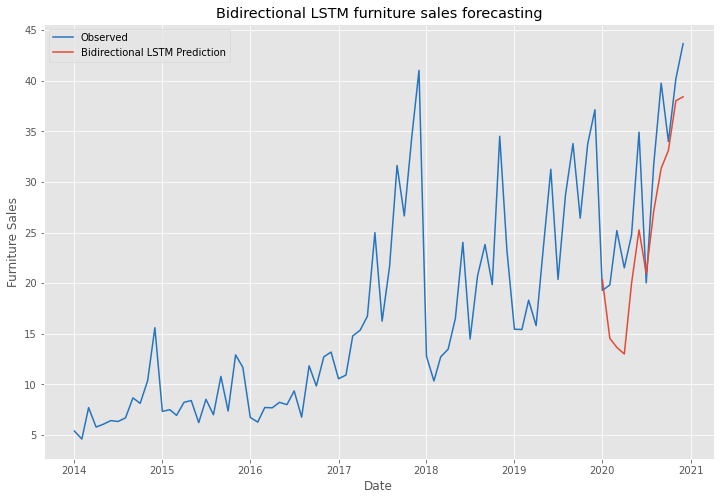

In [46]:
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df[72:].index,df_predict_bi,label="Bidirectional LSTM Prediction")
plt.title('Bidirectional LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [47]:
bi_lstm= performance(df[-12:],df_predict_bi['Prediction'] )
bi_lstm #Bidirectional LSTM

{'MSE': 39.74, 'RMSE': 6.3, 'MAPE': 18.72}

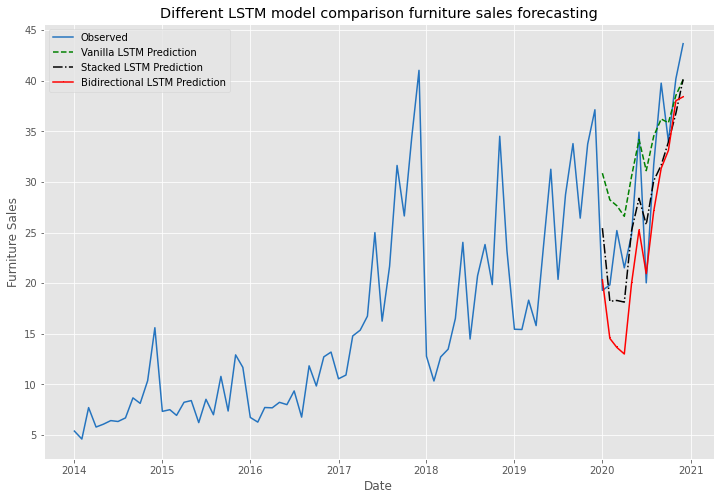

In [48]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
#Vanilla LSTM
plt.plot(df[72:].index,df_predict_vanilla,label="Vanilla LSTM Prediction",linestyle= "--", color='g')
#STacked LSTM
plt.plot(df[72:].index,df_predict_stacked,label="Stacked LSTM Prediction",linestyle= "-.", color="black")
#Bidirectional LSTM
plt.plot(df[72:].index,df_predict_bi,label="Bidirectional LSTM Prediction",marker=',',color='r')
plt.title('Different LSTM model comparison furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend(loc='upper left')
plt.show() # 다 겹친것

In [49]:

X = df.values

In [50]:
# Transform Time Series to Supervised Learning
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
# Make a differenced series to make time-series stationary
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [51]:
# Transform Time Series to Stationary
raw_values = df.values
diff_values = difference(raw_values, 1)

In [52]:
# Transform Time Series to Supervised Learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [53]:
train_size = int(len(df) * 0.75)
trainset, testset= supervised_values[0:-12], supervised_values[-12:]

In [54]:
# Scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [55]:
#  Invert the scale on forecasts to the original scale
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [56]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(trainset, testset)

In [57]:
# fit an LSTM network to train the data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        #epoch can be changed to 1
        model.fit(X, y, epochs=5, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [58]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

Epoch 1/5
71/71 [==============================] - 1s 2ms/step - loss: 0.0971
Epoch 2/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0829
Epoch 3/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0822
Epoch 4/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0815
Epoch 5/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0808
Epoch 1/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0825
Epoch 2/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0794
Epoch 3/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0787
Epoch 4/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0780
Epoch 5/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0773
Epoch 1/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0791
Epoch 2/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0760
Epoch 3/5
71/71 [==============================] - 0s 2ms/step -

71/71 [==============================] - 0s 2ms/step - loss: 0.0627
Epoch 5/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0626
Epoch 1/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0644
Epoch 2/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0625
Epoch 3/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0625
Epoch 4/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0625
Epoch 5/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0624
Epoch 1/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0641
Epoch 2/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0623
Epoch 3/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0623
Epoch 4/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0622
Epoch 5/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0622
Epoch 1/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0

71/71 [==============================] - 0s 2ms/step - loss: 0.0579
Epoch 3/5
71/71 [==============================] - 0s 1ms/step - loss: 0.0578
Epoch 4/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0577
Epoch 5/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0577
Epoch 1/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0595
Epoch 2/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0577
Epoch 3/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0575
Epoch 4/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0574
Epoch 5/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0574
Epoch 1/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0592
Epoch 2/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0574
Epoch 3/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0572
Epoch 4/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0

71/71 [==============================] - 0s 2ms/step - loss: 0.0540
Epoch 2/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0515
Epoch 3/5
71/71 [==============================] - 0s 3ms/step - loss: 0.0513
Epoch 4/5
71/71 [==============================] - 0s 3ms/step - loss: 0.0512
Epoch 5/5
71/71 [==============================] - 0s 3ms/step - loss: 0.0511
Epoch 1/5
71/71 [==============================] - 0s 3ms/step - loss: 0.0537
Epoch 2/5
71/71 [==============================] - 0s 3ms/step - loss: 0.0511
Epoch 3/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0510
Epoch 4/5
71/71 [==============================] - 0s 4ms/step - loss: 0.0509
Epoch 5/5
71/71 [==============================] - 0s 4ms/step - loss: 0.0508
Epoch 1/5
71/71 [==============================] - 0s 3ms/step - loss: 0.0533
Epoch 2/5
71/71 [==============================] - 0s 4ms/step - loss: 0.0508
Epoch 3/5
71/71 [==============================] - 0s 3ms/step - loss: 0.0

71/71 [==============================] - 0s 2ms/step - loss: 0.0439
Epoch 1/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0459
Epoch 2/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0439
Epoch 3/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0437
Epoch 4/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0437
Epoch 5/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0436
Epoch 1/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0455
Epoch 2/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0436
Epoch 3/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0434
Epoch 4/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0434
Epoch 5/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0433
Epoch 1/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0453
Epoch 2/5
71/71 [==============================] - 0s 2ms/step - loss: 0.0

array([[-0.09752657],
       [ 0.5568748 ],
       [ 0.33511218],
       [ 0.3600245 ],
       [ 0.48952353],
       [ 0.37047213],
       [ 0.4145351 ],
       [ 0.4225477 ],
       [ 0.36994097],
       [ 0.39937252],
       [ 0.4161806 ],
       [ 0.19463906],
       [ 0.42102343],
       [ 0.56459826],
       [ 0.29731137],
       [ 0.3970111 ],
       [ 0.39893293],
       [ 0.43615055],
       [ 0.42308325],
       [ 0.36303854],
       [ 0.3898273 ],
       [ 0.3757102 ],
       [ 0.38724846],
       [ 0.3178973 ],
       [ 0.48988158],
       [ 0.46470445],
       [ 0.33291537],
       [ 0.39217287],
       [ 0.43363088],
       [ 0.4009984 ],
       [ 0.4052056 ],
       [ 0.41023308],
       [ 0.37041265],
       [ 0.3435393 ],
       [ 0.4603653 ],
       [ 0.32604778],
       [ 0.46709335],
       [ 0.4666347 ],
       [ 0.27960625],
       [ 0.35649437],
       [ 0.45045185],
       [ 0.07196953],
       [ 0.45061195],
       [ 0.52452004],
       [-0.26221234],
       [ 0

In [59]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [60]:
# walk-forward validation on the test data
predictions_lstm1 = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions_lstm1.append(yhat)
    expected = raw_values[len(train_scaled) + i ]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=31.826310, Expected=37.137931
Month=2, Predicted=17.337244, Expected=19.285714
Month=3, Predicted=22.382281, Expected=19.826087
Month=4, Predicted=19.390630, Expected=25.200000
Month=5, Predicted=25.405841, Expected=21.517241
Month=6, Predicted=27.932785, Expected=24.766667
Month=7, Predicted=24.095108, Expected=34.928571
Month=8, Predicted=22.050374, Expected=20.034483
Month=9, Predicted=26.588309, Expected=31.714286
Month=10, Predicted=26.483585, Expected=39.766667
Month=11, Predicted=45.072659, Expected=34.000000
Month=12, Predicted=42.547176, Expected=40.200000


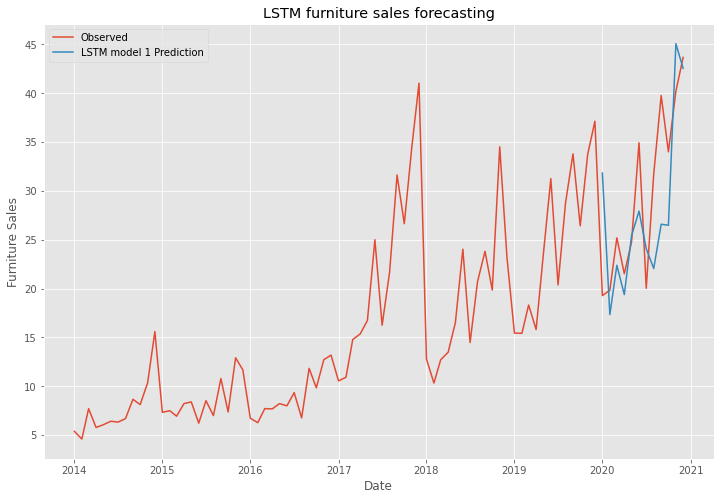

In [61]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed")
plt.plot(df[72:].index,predictions_lstm1,label="LSTM model 1 Prediction")
plt.title('LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [62]:
lstm1= performance(raw_values[-12:], predictions_lstm1)
lstm1

{'MSE': 49.19, 'RMSE': 7.01, 'MAPE': 20.16}